# Cross Validation and Bootsrapping

In [1]:
%matplotlib inline
import tellurium as te
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## Cross Validation Codes

In [2]:
def foldGenerator(num_points, num_folds):
    """
    :param int num_points:
    :param int num_folds:
    :return array, array: training indices, test indices
    """
    indices = range(num_points)
    for remainder in range(num_folds):
        test_indices = []
        for idx in indices:
            if idx % num_folds == remainder:
                test_indices.append(idx)
        train_indices = np.array(list(set(indices).difference(test_indices)))
        test_indices = np.array(test_indices)
        yield train_indices, test_indices
#
generator = foldGenerator(10, 5)
for g in generator:
    print(g)

(array([1, 2, 3, 4, 6, 7, 8, 9]), array([0, 5]))
(array([0, 2, 3, 4, 5, 7, 8, 9]), array([1, 6]))
(array([0, 1, 3, 4, 5, 6, 8, 9]), array([2, 7]))
(array([0, 1, 2, 4, 5, 6, 7, 9]), array([3, 8]))
(array([0, 1, 2, 3, 5, 6, 7, 8]), array([4, 9]))


## Set up data

In [3]:
# Detailed simulation model
COLUMN_NAMES = ["[%s]" % x for x in ['A', 'B', 'C']]
def getSimulationData():
    te.setDefaultPlottingEngine('matplotlib')
    model = """
    model test
        species A, B, C;

        J0: -> A; v0
        A -> B; ka*A;
        B -> C; kb*B;
        J1: C ->; C*kc
        ka = 0.4;
        v0 = 10
        kb = 0.8*ka
        kc = ka

    end
    """
    r = te.loada(model)
    return r.simulate(0, 50, 100)

In [4]:
result = getSimulationData()

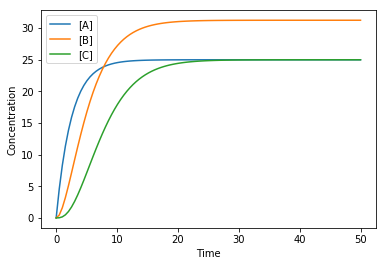

In [5]:
for col in COLUMN_NAMES:
    plt.plot(result['time'], result[col])
plt.xlabel("Time")
plt.ylabel("Concentration")
plt.legend(COLUMN_NAMES)

In [9]:
# Set-up the data
if True:
    STD = 5
    result = getSimulationData()
    length = len(result)
    XV = result['time']
    XV = XV.reshape(length, 1)
    ERRORS = np.array(np.random.normal(0, STD, length))
    YV_PURE = result['[B]']
    YV = YV_PURE + ERRORS
    YV_PURE = YV_PURE.reshape(length, 1)
    YV = YV.reshape(length, 1)

## Cross Validation

In [7]:
# Does a polynomial regression of the specified order
def buildMatrix(xv, order):
    """
    :param array-of-float xv:
    :return matrix:
    """
    length = len(xv)
    xv = xv.reshape(length)
    constants = np.repeat(1, length)
    constants = constants.reshape(length)
    data = [constants]
    for n in range(1, order+1):
        data.append(xv*data[-1])
    mat = np.matrix(data)
    return mat.T

def regress(xv, yv, train, test, order=1):
    """
    :param array-of-float xv: predictor values
    :param array-of-float yv: response values
    :param array-of-int train: indices of training data
    :param array-of-int test: indices of test data
    :param int order: Order of the polynomial regression
    return float, array-float, array-float: R2, y_test, y_preds
    """  
    regr = linear_model.LinearRegression()
    # Train the model using the training sets
    mat_train = buildMatrix(xv[train], order)
    regr.fit(mat_train, yv[train])
    mat_test = buildMatrix(XV[test], order)
    y_pred = regr.predict(mat_test)
    rsq = r2_score(YV[test], y_pred)
    return rsq, yv[test], y_pred, regr.coef_

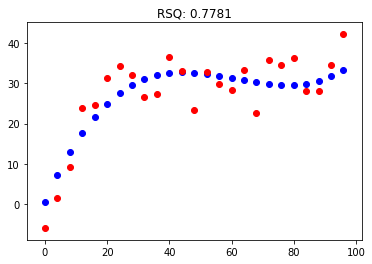

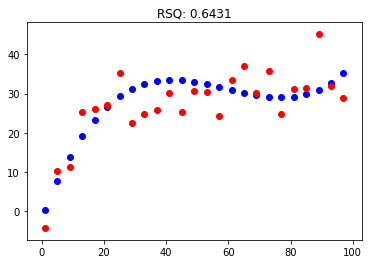

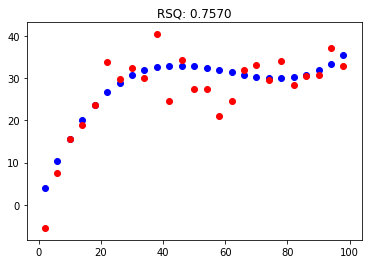

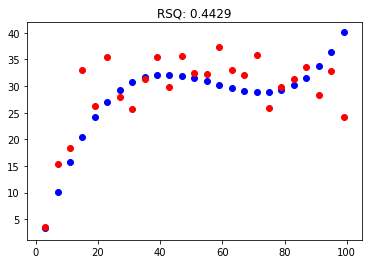

In [10]:
generator = foldGenerator(100, 4)
for train, test in generator:
    rsq, yv_test, yv_pred, coef_ = regress(XV, YV, train, test, order=3)
    plt.figure()
    plt.scatter(test, yv_pred, color = 'b')
    plt.scatter(test, yv_test, color = 'r')
    plt.title("RSQ: %2.4f" % rsq)

## Bootstrapping

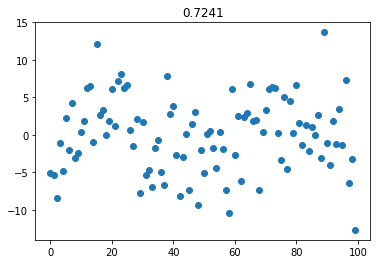

In [12]:
# Compute residuals
train = range(len(XV))
test = range(len(XV))
rsq, yv_test, yv_pred, _ = regress(XV, YV, train, test, order=3)
residuals = yv_test - yv_pred
plt.scatter(test, residuals)
_ = plt.title("%2.4f" % rsq)

In [15]:
# Generate synthetic data from residuals
def generateData(y_obs, y_fit):
    """
    :param np.array y_obs
    :param np.array y_fit
    :return np.array: bootstrap data
    """
    residuals = y_obs - y_fit
    length = len(y_obs)
    residuals = residuals.reshape(length)
    samples = np.random.randint(0, length, length)
    result = y_fit + residuals[samples]
    result = result.reshape(length)
    return result

In [19]:
y_obs = np.array([1, 2, 3])
y_fit = np.array([.9, 2.4, 3.2])
for _ in range(4):
    print (generateData(y_obs, y_fit))

[1.  2.5 3.3]
[0.5 2.  2.8]
[0.5 2.  2.8]
[0.7 2.2 3. ]


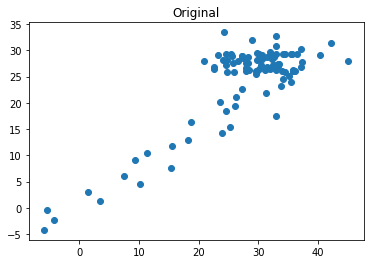

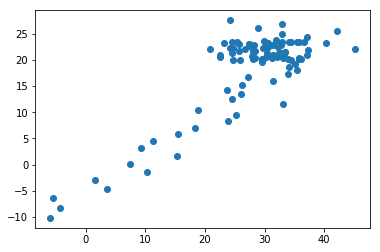

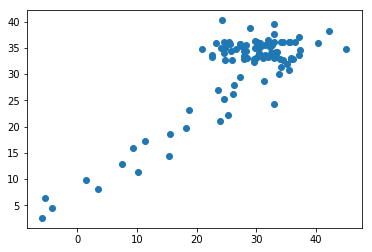

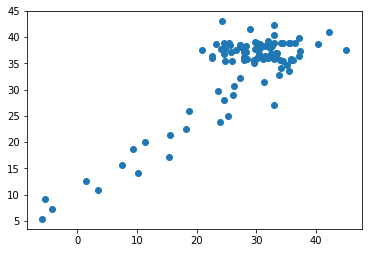

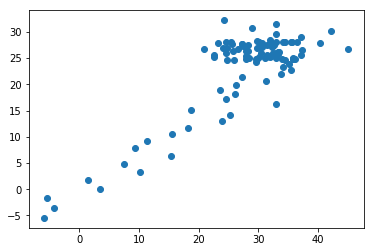

In [16]:
train = range(len(XV))
rsq, yv_test, yv_pred, _ = regress(XV, YV, train, train, order=3)
plt.scatter(YV, generateData(YV, yv_pred))
plt.title("Original")
for _ in range(4):
    plt.figure()
    plt.scatter(YV, generateData(YV, yv_pred))

In [ ]:
# Estimate the parameters for each random data set
train = range(len(XV))
coefs = []
_, _, y_fit, _ = regress(XV, YV, train, train, order=3)
for _ in range(10):
    yv = generateData(YV, y_fit)
    _, _, _, coef_ = regress(XV, yv, train, train, order=3)
    coefs.append(coef_)
coefs